# Практическая работа по кластеризации данных с помощью метода k-средних.

# Import библиотек

In [1]:
import numpy as np # библиотека Numpy для операций линейной алгебры и прочего
import pandas as pd # Библиотека Pandas для работы с табличными данными


from sklearn.preprocessing import StandardScaler
import sklearn.datasets as ds

from sklearn import preprocessing as prep

from sklearn.metrics import silhouette_samples # функция scikit-learn для оценки Коэффициента Силлуэта

import seaborn as sns# библиотека Seaborn для визуализации данных из Pandas

import matplotlib # библиотека Matplotlib для визуализации
import matplotlib.pyplot as plt # библиотека Matplotlib для визуализации
# по разному импортируем потому что в модуле pyplot много рисования (и удобней сократить при применении),
# но нам понадобится ещё кое-что из matplotlib

from sklearn.cluster import KMeans # Кластеризация К-Средних от scikit-learn

plt.style.use('dark_background')

In [2]:
def plot_silhouette_results(X,centroids,labels, label_centroids, axis_x, axis_y):
    """Визуализация результатов кластеризации и коэффициентов силуэта
    Входные переменные:
    ===========
    X: признаки
    centroids: центры кластеров
    labels: метки кластеров для данных
    centroids: метки центров кластеров
    axis_x: какую ось рисовать в качестве Х
    axis_y: какую ось рисовать в качестве У
    """

    # создаем большое полотно
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(25  , 5)

    # считаем коэффициенты силуэта через функцию scikit-learn
    silhouette_vals = silhouette_samples(X, labels)

    # выбираем цветовую карту - мне нравится 'bwr'
    cmap = matplotlib.colormaps['bwr']
    y_lower, y_upper = 0, 0
    # перебираем все метки кластеров
    for i, cluster in enumerate(np.unique(labels)):
        # отбираем коэффициент силуэта для текущей метки
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        # сортируем
        cluster_silhouette_vals.sort()

        # визуализируем
        # определяем верхнюю границу рисования (по вертикали
        y_upper += len(cluster_silhouette_vals)  # как количество объектов с текущей меткой
        c = cluster /max(labels) # считаем "координату" метки кластера в цветовой карте
        # с помощью горизонтальных полос визуализируем коэффициенты силуэта
        ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals,color = cmap(c), edgecolor='none', height=1)
        # "слева" напишем номер метки кластеров
        ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
        # переопределим нижнюю границу рисования  (по вертикали)
        y_lower += len(cluster_silhouette_vals)  # (предыдущая верхняя граница)

    # оцениваем среднее значение коэффициента силлуэта
    avg_score = np.mean(silhouette_vals)
    # визуализируем через вертикальную линию
    ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
    ax1.set_yticks([])
    ax1.set_xlim([-0.1, 1])
    ax1.set_xlabel('Коэффициент Силуэта')
    ax1.set_ylabel('Кластеры')


    # визуализируем данные с подракашиванием
    # сначала сами данные
    ax2.scatter(X[:, axis_x], X[:, axis_y], c=labels, alpha = 0.7,  cmap = 'bwr',)
    # а потом центры кластеров, но большими кругами
    ax2.scatter(centroids[:, axis_x], centroids[:, axis_y], c=label_centroids, cmap = 'bwr', edgecolors = 'k', s=400)
    ax2.set_xlabel(new_names[axis_x])
    ax2.set_ylabel(new_names[axis_y])
    ax2.set_aspect('equal')
    plt.tight_layout();

In [3]:
def plot_multi(data, y,  names, sub, size):
    axis = [[0,1],
            [2,1],
            [0,3],
            [2,3],]


    labels = [['',names[1]],
            ['',''],
            [names[0],names[3]],
            [names[2],'']]



    for n, (axi, label, ax) in enumerate(zip(axis,  labels, sub.flatten())):
        scatter = ax.scatter(data[:,axi[0]],data[:,axi[1]],
                             c=y, s = size, cmap = 'bwr',
                             alpha = 0.7, facecolors = 'none' );
        ax.set_ylabel(label[1], fontsize = 20)
        ax.set_xlabel(label[0], fontsize = 20)
        ax.tick_params(axis='x', labelsize= 15)
        ax.tick_params(axis='y', labelsize= 15)
        ax.grid()
        legend1 = ax.legend(*scatter.legend_elements(),
                        loc="upper left", title="Clusters",
                        fontsize = 15)
        ax.add_artist(legend1)

# Набор данных - Ирисы

Данные Ирисов, используемые в задачах классификации

```
The iris dataset is a classic and very easy multi-class classification dataset.
=================   ==============
Classes                          3
Samples per class               50
Samples total                  150
Dimensionality                   4
Features            real, positive
=================   ==============
```

In [4]:
data_iris = ds.load_iris()

In [6]:
DF = pd.DataFrame(data_iris.data, columns=data_iris.feature_names)
new_names = ['sep_len', 'sep_wid', 'pet_len', 'pet_wid']
DF = DF.set_axis(new_names, axis = 'columns')
DF

,sep_len,sep_wid,pet_len,pet_wid
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


Стандартизируем данные

In [7]:
Standard = prep.StandardScaler().fit(DF[['sep_len', 'sep_wid', 'pet_len', 'pet_wid']])
Standard.mean_, Standard.scale_

(array([5.84333333, 3.05733333, 3.758     , 1.19933333]),
 array([0.82530129, 0.43441097, 1.75940407, 0.75969263]))

In [8]:
scaled = Standard.transform(DF[['sep_len', 'sep_wid', 'pet_len', 'pet_wid']])
DF_scaled = pd.DataFrame(scaled, columns = ['sep_len_sc','sep_wid_sc','pet_len_sc','pet_wid_sc'])
DF_scaled

,sep_len_sc,sep_wid_sc,pet_len_sc,pet_wid_sc
0,-0.900681,1.019004,-1.340227,-1.315444
1,-1.143017,-0.131979,-1.340227,-1.315444
2,-1.385353,0.328414,-1.397064,-1.315444
3,-1.506521,0.098217,-1.283389,-1.315444
4,-1.021849,1.249201,-1.340227,-1.315444
...,...,...,...,...
145,1.038005,-0.131979,0.819596,1.448832
146,0.553333,-1.282963,0.705921,0.922303
147,0.795669,-0.131979,0.819596,1.053935
148,0.432165,0.788808,0.933271,1.448832


# Кластеризация K-means

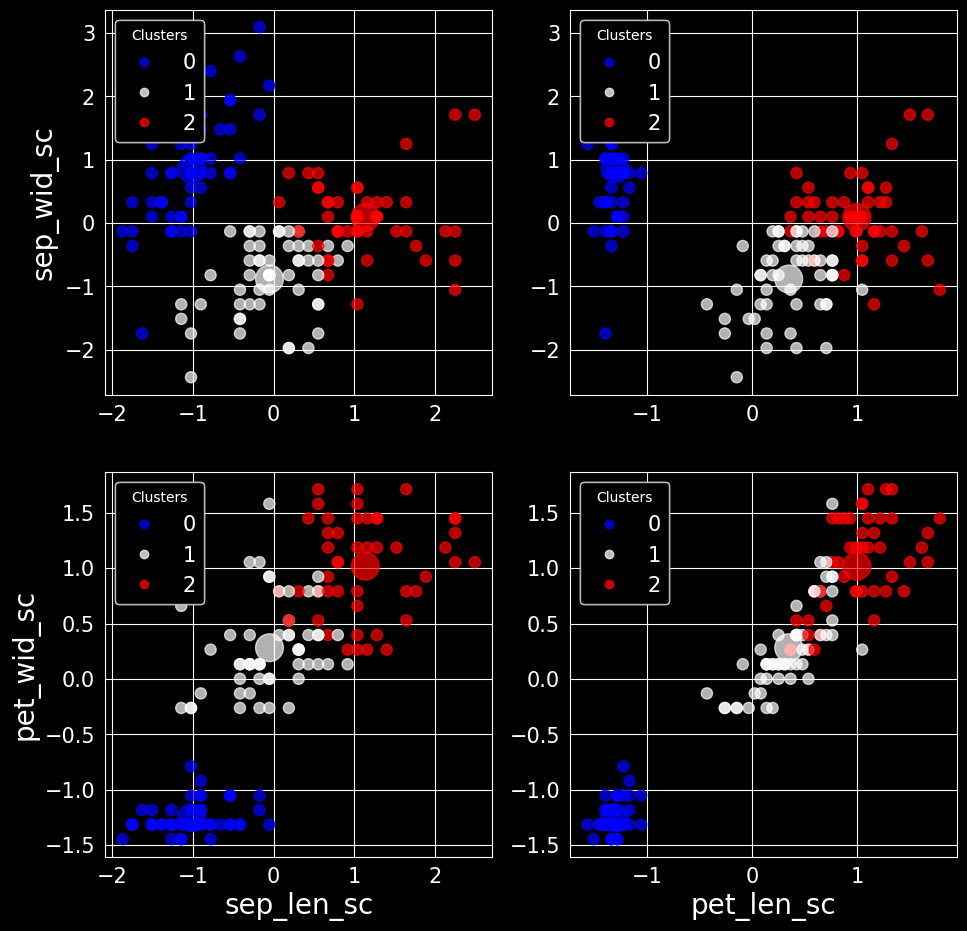

In [9]:
#@title Кластеризация k-Means { run: "auto" }
#@markdown ### Данные (оригинальные или стандартизированные)
dataframe = DF_scaled  #@param [ "DF" , "DF_scaled"]{type:"raw"}
#@markdown ### Число кластеров
k = 3 #@param {type:"slider", min:2, max:10, step:1}

X = dataframe.values

# создаем объект
km = KMeans(n_clusters=k,
            n_init = 10)

# обучаем на данных
km.fit(X)
# предсказываем метки кластеров для данных
labels = km.predict(X)
# "забираем" координаты центров
centroids = km.cluster_centers_
# предсказываем метки для центроидов
label_centroids = km.predict(centroids)

#Визуализация 4-х проекций данных
fig, sub = plt.subplots(2, 2, figsize = (11,11))
plot_multi(X, labels,
           dataframe.columns,
           sub, size = 64);


plot_multi(centroids, label_centroids,
           dataframe.columns,
           sub, size = 400);

In [10]:
df_temp = pd.DataFrame(data = data_iris.target, columns = ['target'])
df_temp['labels'] = labels
pd.crosstab(df_temp['labels'], df_temp['target'])

target,0,1,2
labels,,,
0,50,0,0
1,0,39,14
2,0,11,36


# Оценка количества кластеров методом "Локоть"

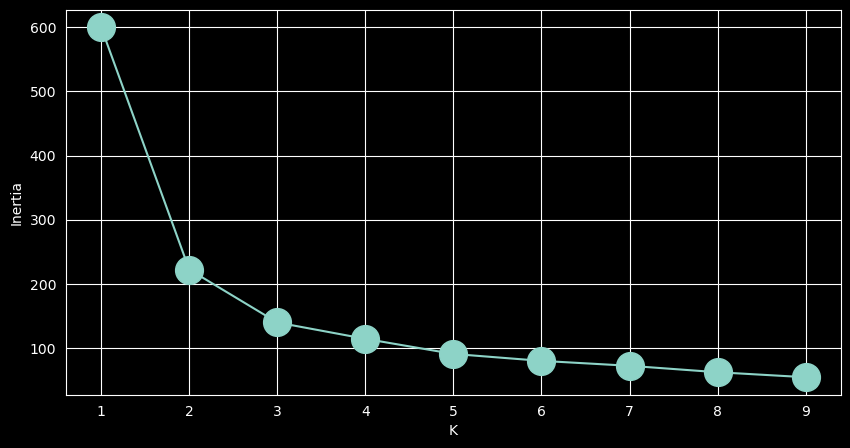

In [11]:
#@title Оценка количества кластеров методом «Локоть» { run: "auto" }
#@markdown ### Данные (оригинальные или стандартизированные)

dataframe = DF_scaled  #@param [ "DF" , "DF_scaled"]{type:"raw"}
X = dataframe.values

sse = [] # здесь будем хранить инерции для конкретных к
list_k = list(range(1, 10))
for k in list_k: # тестируем различные к в диапазоне от 1 до 10
    km = KMeans(n_clusters=k, # создаем объект кластеризации с заданным к
            n_init = 10)
    km.fit(X) # обучаем
    sse.append(km.inertia_) # фиксируем текущую инерцию

# визуализируем метод локтя

plt.figure(figsize=(10, 5))
plt.plot(list_k, sse, '-o', markersize = 20)
plt.xlabel('K')
plt.ylabel('Inertia');

# Коэффициент силуэта для результатов кластеризации

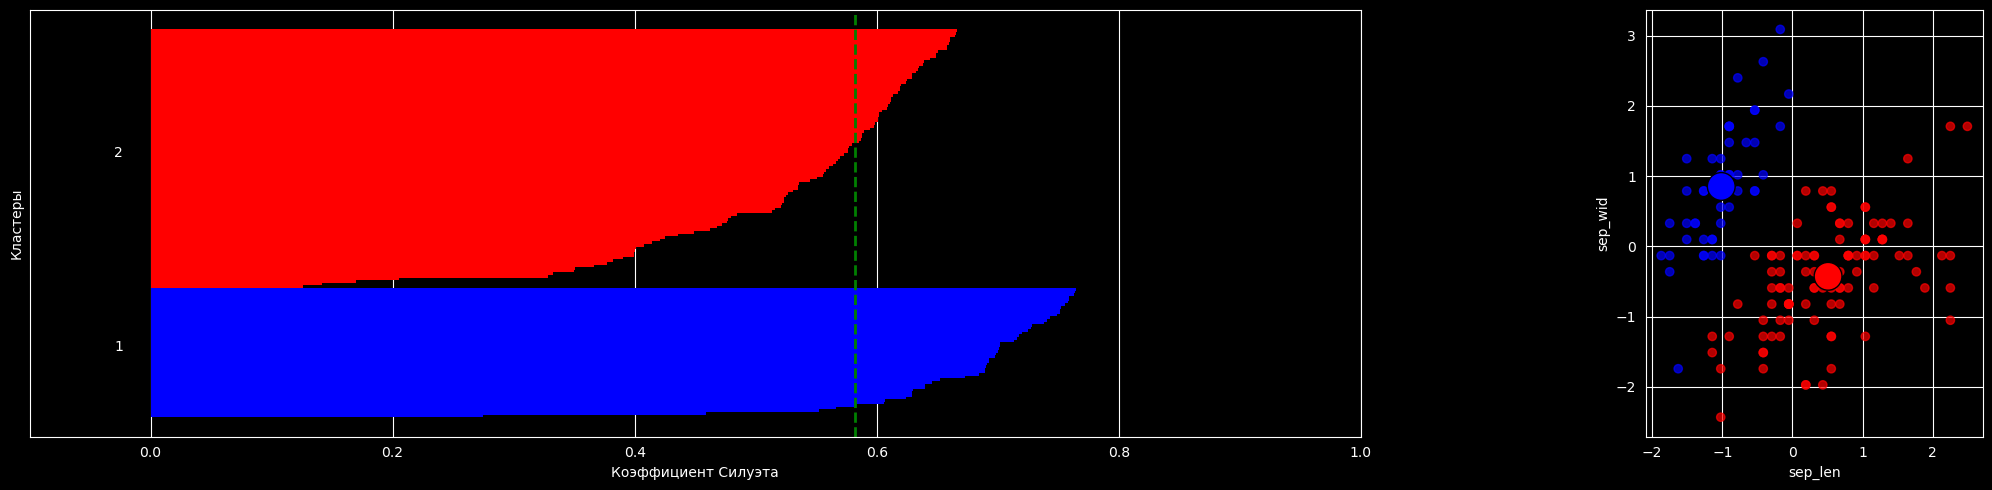

In [12]:
#@title Коэффициент силуэта для реультатов кластеризации { run: "auto" }
#@markdown ### Данные (оригинальные или стандартизированные)
dataframe = DF_scaled  #@param [ "DF" , "DF_scaled"]{type:"raw"}
#@markdown ### Число кластеров
k = 2 #@param {type:"slider", min:2, max:10, step:1}
#@markdown ### Оси для отрисовки
#@markdown ### Ось x
axis_x = 0 #@param {type:"slider", min:0, max:3, step:1}
#@markdown ### Ось y
axis_y = 1 #@param {type:"slider", min:0, max:3, step:1}

X = dataframe.values
# создаем объект
km = KMeans(n_clusters=k,
            n_init = 10)
# обучаем на данных
km.fit(X)
# предсказываем метки кластеров для данных
labels = km.predict(X)
# "забираем" координаты центров
centroids = km.cluster_centers_
# предсказываем метки для центроидов
label_centroids = km.predict(centroids)
# Визуализация и данных, и коэффициентов силуэта
plot_silhouette_results(X,centroids,
                        labels, label_centroids,
                        axis_x, axis_y)